In [22]:
import os
import laspy as lp
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.mixture import GaussianMixture


def read_las_file(las_path):
    try:
        return lp.read(las_path)
    except Exception as e:
        print(f"Error reading {las_path}: {e}")
        return None

def normalize_colors(colors):
    rgba = colors - colors.min(axis=0)
    rgba = rgba / rgba.max(axis=0)
    return (rgba * 255).astype(np.uint8)

def normalize_points(points, eps= 1e-8):
    if not isinstance(points, np.ndarray) or points.shape[1] != 3:
        raise ValueError("points must be a numpy array with shape (n, 3).")
    points_ = points.copy()

    x_min, x_max = np.min(points_[:,0]), np.max(points_[:,0])
    y_min, y_max = np.min(points_[:,1]), np.max(points_[:,1])
    z_min, z_max = np.min(points_[:,2]), np.max(points_[:,2])

    points_[:,0] = (points_[:,0] - x_min) / (x_max - x_min + eps)
    points_[:,1] = (points_[:,1] - y_min) / (y_max - y_min + eps)
    points_[:,2] = (points_[:,2] - z_min) / (z_max - z_min + eps)
    
    return points_, x_min, x_max, y_min, y_max, z_min, z_max  

def get_points_and_colors(las_paths: list, limit: int = -1):
    if not isinstance(las_paths, list) or not all(isinstance(path, str) for path in las_paths):
        raise ValueError("las_paths must be a list of strings.")

    if not isinstance(limit, int) or limit < -1:
        raise ValueError("limit must be an integer greater than or equal to -1.")

    points = []
    colors = []
    classes = []

    for las_path in las_paths:
        las = read_las_file(las_path)
        if las is not None:
            points.append(np.vstack((las.x, las.y, las.z)).transpose())
            colors.append(np.vstack((las.red, las.green, las.blue)).transpose())
            classes.append(las.classification)

    if not points:
        raise ValueError("No valid LAS files found.")

    points = np.vstack(points)
    colors = np.vstack(colors)
    classes = np.hstack(classes)

    if limit > 0:
        idxs = np.random.choice(len(points), limit, replace=False)
        points = points[idxs]
        colors = colors[idxs]
        classes = classes[idxs]

    rgba_colors = normalize_colors(colors)

    return points, colors, rgba_colors, classes

def automatic_gmm_components(data, max_components=2, criterion='aic', T=0.1, **kwargs):
    n_components_range = range(1, max_components + 1)
    criterions, means = [], []
    if criterion not in ['aic', 'bic']:
        raise ValueError("Criterio no válido. Usa 'bic' o 'aic'.")
    
    for n in n_components_range:
        try:
            gmm = GaussianMixture(n_components=n, **kwargs)
            gmm.fit(data)
            criterions.append(gmm.bic(data)) if criterion == 'bic' else criterions.append(gmm.aic(data))
            means.append(gmm.means_)
        except ValueError as e:
            print(f"Error fitting GMM with {n} components: {e}")
            break
    
    if means[0] - means[1] <= T:
        return 1, [np.mean(data)]
    
    if not criterions:
        return 1, [np.mean(data)]  # Si no se pudo ajustar ningún modelo, devolver 1 componente
    
    # Seleccionar el número de componentes con el menor valor del criterio
    optimal_components = n_components_range[np.argmin(criterions)]
    return optimal_components, means



In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Generar datos sintéticos de dos gaussianas
z_test = np.concatenate([
    np.random.normal(-1, 0.5, 100),
    np.random.normal(1, 0.5, 100)
])

# Determinar número óptimo de componentes con AIC
optimal_n = automatic_gmm_components(z_test.reshape(-1,1), criterion='aic ')
print(optimal_n)

# Ajustar el modelo final
gmm_optimal = GaussianMixture(n_components=optimal_n, random_state=42)
gmm_optimal.fit(z_test.reshape(-1,1))

# Crear grid para evaluación
x_axis = np.linspace(min(z_test)-1, max(z_test)+1, 1000).reshape(-1, 1)

# Calcular componentes individuales
plt.figure(figsize=(10, 6))

# Histograma
plt.hist(z_test, bins=30, density=True, alpha=0.6, color='g', label='Datos')

# Mezcla completa
logprob = gmm_optimal.score_samples(x_axis)
plt.plot(x_axis, np.exp(logprob), 'k-', linewidth=2, label='Mezcla completa')

# Componentes individuales
for i in range(gmm_optimal.n_components):
    # Calcular PDF para cada componente
    pdf = (
        gmm_optimal.weights_[i]
        * np.exp(-0.5 * ((x_axis - gmm_optimal.means_[i])/gmm_optimal.covariances_[i]**0.5)**2)
        / (gmm_optimal.covariances_[i]**0.5 * np.sqrt(2 * np.pi))
    )
    plt.plot(x_axis, pdf, '--', label=f'Componente {i+1}')

plt.title('Distribución de z con componentes GMM')
plt.xlabel('Valor de z')
plt.ylabel('Densidad')
plt.legend()
plt.show()

(2, [array([[-0.05309395]]), array([[-1.04596572],
       [ 0.92891481]]), array([[ 1.14629305],
       [-1.08004608],
       [ 0.37285303]]), array([[ 1.11114166],
       [-0.84565479],
       [ 0.22933014],
       [-1.47601131]]), array([[-1.47542963],
       [ 0.26264749],
       [ 1.54982252],
       [-0.83988775],
       [ 1.00541949]]), array([[-0.5391859 ],
       [ 1.25581994],
       [-2.03589587],
       [ 0.64299381],
       [-0.97682965],
       [-1.52409724]]), array([[ 1.49343498],
       [-0.74709932],
       [ 0.37181627],
       [-1.67780698],
       [-0.16552438],
       [ 0.97647503],
       [-1.17425094]]), array([[-0.63714504],
       [-1.58445802],
       [ 1.1858481 ],
       [ 0.37483353],
       [-1.03727742],
       [ 1.56017765],
       [ 0.88244722],
       [-0.18115183]]), array([[ 0.38553617],
       [-1.28825894],
       [ 1.56821446],
       [-0.63533486],
       [ 0.89265578],
       [-1.68726317],
       [-0.96680337],
       [-0.19147254],
       [ 1.

InvalidParameterError: The 'n_components' parameter of GaussianMixture must be an int in the range [1, inf). Got (2, [array([[-0.05309395]]), array([[-1.04596572],
       [ 0.92891481]]), array([[ 1.14629305],
       [-1.08004608],
       [ 0.37285303]]), array([[ 1.11114166],
       [-0.84565479],
       [ 0.22933014],
       [-1.47601131]]), array([[-1.47542963],
       [ 0.26264749],
       [ 1.54982252],
       [-0.83988775],
       [ 1.00541949]]), array([[-0.5391859 ],
       [ 1.25581994],
       [-2.03589587],
       [ 0.64299381],
       [-0.97682965],
       [-1.52409724]]), array([[ 1.49343498],
       [-0.74709932],
       [ 0.37181627],
       [-1.67780698],
       [-0.16552438],
       [ 0.97647503],
       [-1.17425094]]), array([[-0.63714504],
       [-1.58445802],
       [ 1.1858481 ],
       [ 0.37483353],
       [-1.03727742],
       [ 1.56017765],
       [ 0.88244722],
       [-0.18115183]]), array([[ 0.38553617],
       [-1.28825894],
       [ 1.56821446],
       [-0.63533486],
       [ 0.89265578],
       [-1.68726317],
       [-0.96680337],
       [-0.19147254],
       [ 1.19271739]]), array([[-0.63482439],
       [ 0.91426062],
       [-1.28439855],
       [ 0.22867583],
       [ 1.82135376],
       [-1.68174716],
       [ 1.31979544],
       [-0.17957325],
       [-0.96542132],
       [ 0.45801916]])]) instead.

In [17]:
name_project = 'poza1b'
path_project = f'../data/{name_project}' 

las_paths = [f'{path_project}/{filename}' for filename in os.listdir(path_project) if filename.endswith('.las')]
points, colors, rgba_colors, classes = get_points_and_colors(las_paths, limit=1000)

points.shape, colors.shape, rgba_colors.shape, classes.shape

((1000, 3), (1000, 3), (1000, 3), (1000,))

In [18]:
print(f'h: {np.max(points[:,0]) - np.min(points[:,0])}')
print(f'w: {np.max(points[:,1]) - np.min(points[:,1])}')

h: 1026.402499999851
w: 817.1627500001341


  0%|          | 0/1000 [00:00<?, ?it/s]

[array([[0.36351459]]), array([[0.35952542],
       [0.36750375]])]
1
[array([[0.39717962]]), array([[0.39731994],
       [0.39703929]])]
1
[array([[0.38321017]]), array([[0.38013366],
       [0.38628669]])]
1
[array([[0.38591869]]), array([[0.39523655],
       [0.37660082]])]
2


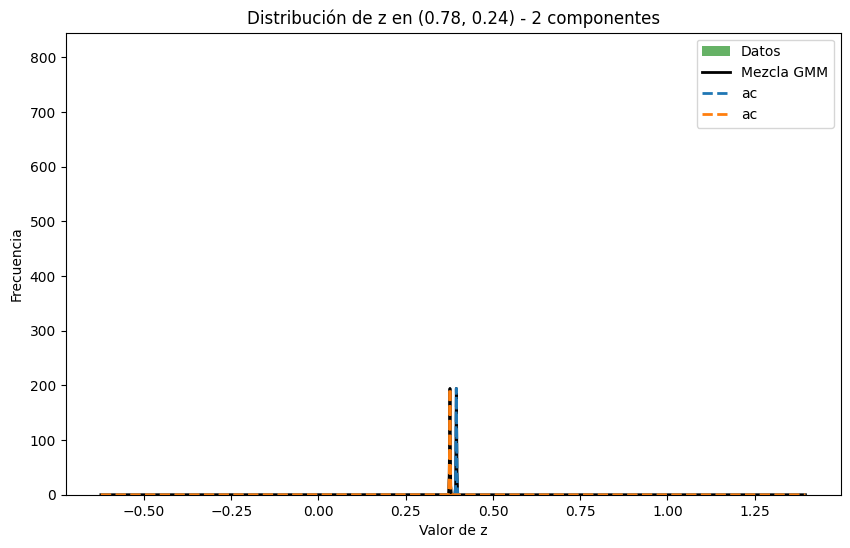

 11%|█         | 111/1000 [00:00<00:01, 501.17it/s]


In [23]:
# Definir el tamaño de la vecindad
result = []
neighborhood_size = 1 # transforma a metro 
x,y,z = points[:,0], points[:,1], points[:,2]

points_norm, x_min, x_max, y_min,y_max, z_min, z_max = normalize_points(points)
x_norm,y_norm,z_norm = points_norm[:,0], points_norm[:,1], points_norm[:,2]

neighborhood_size_x = neighborhood_size / (x_max - x_min + 1e-8)
neighborhood_size_y = neighborhood_size / (y_max - y_min + 1e-8)

# Iterar sobre cada punto (x, y)
for i in tqdm(range(len(x))):
    # Filtrar los puntos en la vecindad
    px, py, pz = x_norm[i], y_norm[i], z_norm[i] 
    ## obtener todo los puntos de la venciddad de px py
    ## utlizar kdtree para la vencidad
    mask = (np.abs(x_norm - px) < neighborhood_size_x) & (np.abs(y_norm - py) < neighborhood_size_y)
    z_neighborhood = z_norm[mask]

    if len(z_neighborhood) < 2:
        continue

    z_neighborhood = z_neighborhood.reshape(-1, 1)

    # Encontrar y ajustar el modelo óptimo
    optimal_n_components, means = automatic_gmm_components(z_neighborhood, max_components=2)
    
    result.append([x_norm[i], y_norm[i], z_norm[i], optimal_n_components])

    print(optimal_n_components)
    if optimal_n_components >= 2:

        gmm_optimal = GaussianMixture(n_components=optimal_n_components, random_state=42)
        gmm_optimal.fit(z_neighborhood)

        # Preparar datos para la gráfica
        x_min_, x_max_ = z_neighborhood.min() - 1, z_neighborhood.max() + 1
        x_axis = np.linspace(x_min_, x_max_, 1000).reshape(-1, 1)
        
        # Calcular componentes
        logprob = gmm_optimal.score_samples(x_axis)
        individual_pdfs = np.exp(gmm_optimal.score_samples(x_axis))  # PDF de la mezcla completa

        # Configurar la gráfica
        plt.figure(figsize=(10, 6))
        plt.hist(z_neighborhood, bins=30, density=True, alpha=0.6, color='g', label='Datos')
        plt.plot(x_axis, np.exp(logprob), 'k-', lw=2, label='Mezcla GMM')

        # Graficar componentes individuales
        for j in range(gmm_optimal.n_components):
            weight = gmm_optimal.weights_[j]
            mean = gmm_optimal.means_[j, 0]
            std = np.sqrt(gmm_optimal.covariances_[j, 0])
            
            component_pdf = weight * (1/(std * np.sqrt(2 * np.pi))) * \
                        np.exp(-0.5 * ((x_axis - mean)/std)**2)
            
            plt.plot(x_axis, component_pdf, '--', lw=2, 
                    label='ac') #f'Componente {j+1} ($\mu$={mean:.2f}, $\sigma$={std:.2f})')
        plt.title(f'Distribución de z en ({x_norm[i]:.2f}, {y_norm[i]:.2f}) - {optimal_n_components} componentes')
        plt.xlabel('Valor de z')
        plt.ylabel('Frecuencia')
        plt.legend()
        plt.show()
        break     